In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets 
from sklearn.mixture import GaussianMixture
import pandas as pd
from pandas import DataFrame 
import scipy.sparse as sp
import igraph as ig
import math

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), max(self.ix , x), max(self.iy , y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), max(self.ix , x), max(self.iy , y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [3]:
def run(filename: str):
    COLORS = {'BLACK' : [0,0,0],'RED'   : [0, 0, 255],'GREEN' : [0, 255, 0],'BLUE'  : [255, 0, 0],'WHITE' : [255,255,255]}

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {'RECT' : (0, 0, 1, 1),'DRAW_STROKE': False,'DRAW_RECT' : False,'rect_over' : False,'rect_or_mask' : -1,'value' : DRAW_FG}

    img = cv2.imread(filename)
    #mg=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    img2 = img.copy()                               
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = img.copy()        # output image to be shown
    img1=img.copy()
    # Input and segmentation windows
    cv2.namedWindow('Input Image',cv2.WINDOW_GUI_NORMAL)
    cv2.namedWindow('Segmented output',cv2.WINDOW_GUI_NORMAL)
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    out_box=np.zeros(img.shape)
    box=[0,0,1,1]
    out_box[box[1]:box[3],box[0]:box[2],:]=1
    unknown_part=img[box[1]:box[3],box[0]:box[2],:]
    out_start=out_box.copy()
    flag=False
    ll=0
    while(1):
        mask = EventObj.mask
        FLAGS = EventObj.flags
        img = EventObj.image
        cv2.imshow('Input Image', img)
        k = cv2.waitKey(1)
        box=[1,1,1,1]
        if k == 27:
            cv2.destroyAllWindows()
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
            print(out_box.shape,img.shape)
            out_box[np.where(np.sum(img,axis=2)==0)]=0
            print(FLAGS['value'])
            plt.imshow(out_box,'gray')
            plt.show()
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
            print(FLAGS['value'])
            out_box[np.where(img)==255]=1
            plt.imshow(out_box,'gray')
            plt.show()
            cv2.destroyAllWindows()
            return out_box+1
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        elif k== ord('2'):
            bbox=FLAGS['RECT']
            box[0]=bbox[0]
            box[1]=bbox[1]
            box[2]=bbox[2]+bbox[0]
            box[3]=bbox[3]+bbox[1]
            print(box)
            cv2.destroyAllWindows()
            #box_shape=rect(box,img1)
            #out_box=np.zeros(img.shape[:2])
            #out_box[box[1]:box[3],box[0]:box[2]]=1
            #unknown_part=img1[box[1]:box[3],box[0]:box[2],:]
            #out_start=out_box.copy()
            return box
        elif k == 13: 
            print("hi")
            if(flag==False):
                box=FLAGS['RECT']
            #print(FLAGS['RECT'])
            #output=runner(img,box,10)
        cv2.imshow('Segmented image',output)
        #img=output.copy()
        #EventObj.flags = FLAGS
        #mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        #output = cv2.bitwise_and(img2, img2, mask = mask2)
        #plt.imshow(output)

hi
{'color': [255, 255, 255], 'val': 1}


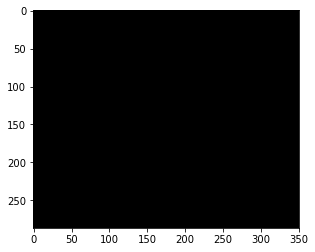

In [7]:
mult=run('./../../lib.png')

In [8]:
np.save('library',mult)
here=np.load('library.npy')
print(here)

[[[2. 2. 2.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


In [21]:
#print(mult)
np.save('farm',mult)
here=np.load('farm.npy')
print(here)

[[[2. 2. 2.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


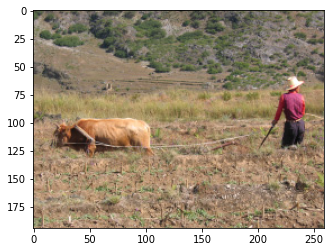

In [6]:
img=cv2.imread('./../../hi.png')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [6]:
def normm(img1,img2):
    if (img1.std()==0 or img2.std()==0):
        return 0
    up=np.mean((img1-img1.mean())*(img2-img2.mean()))
    down=(img1.std()*img2.std())
    return up/down
def corr_match(img1,img2,xx):
    mp1=[]
    mp2=[]
    d={}
    l=0
    x,y=xx[0],xx[1]
    #img2=cv2.resize(img2,(img1.shape[1],img1.shape[0]))
    for i in range((img1.shape[0]-x)):
        for j in range((img1.shape[1]-y)):
            img=img1[i:i+x,j:j+y].copy()
            corr=0
            mp1.append((i,j))
            mp2.append((0,0))
            for ii in range((img2.shape[0]-x)):
                for jj in range((img2.shape[1]-y)):
                    temp=img2[ii:ii+x,jj:jj+y].copy()
                    corr_temp=normm(img,temp)
                    if(corr_temp>corr):
                        mp2[l]=(ii,jj)
                        corr=corr_temp
            d[i,j]=mp2[l]
            l=l+1
    return d
def corr_match1(img1,img2,xx):
    mp1=[]
    mp2=[]
    d={}
    l=0
    x,y=xx[0],xx[1]
    #img2=cv2.resize(img2,(img1.shape[1],img1.shape[0]))
    for i in range((img1.shape[0]-x)):
        for j in range((img1.shape[1]-y)):
            img=img1[i:i+x,j:j+y].copy()
            corr=0
            mp1.append((i,j))
            mp2.append((0,0))
            for ii in range((img2.shape[0]-x)):
                for jj in range((img2.shape[1]-y)):
                    temp=img2[ii:ii+x,jj:jj+y].copy()
                    corr_temp=normm(img,temp)
                    if(corr_temp>corr):
                        mp2[l]=(ii,jj)
                        corr=corr_temp
            d[i,j]=mp2[l]
            l=l+1
    return d
def corr_match2(img1,img2,xx):
    mp1=[]
    mp2=[]
    d={}
    l=0
    x,y=xx[0],xx[1]
    #img2=cv2.resize(img2,(img1.shape[1],img1.shape[0]))
    for i in range((img1.shape[0]-x)):
        for j in range((img1.shape[1]-y)):
            img=img1[i:i+x,j:j+y].copy()
            corr=0
            mp1.append((i,j))
            mp2.append((0,0))
            for ii in range((img2.shape[0]-x)):
                for jj in range((img2.shape[1]-y)):
                    temp=img2[ii:ii+x,jj:jj+y].copy()
                    corr_temp=normm(img,temp)
                    if(corr_temp>corr):
                        mp2[l]=(ii,jj)
                        corr=corr_temp
            d[mp2[l]]=(i,j)
            l=l+1
    return d

In [15]:
from numpy.linalg import norm
def PP(a,l=5,s=5):
    x = np.arange(0,a.shape[1]-s+1,1)
    y = np.arange(0,a.shape[0]-s+1,1)
    x,y = np.meshgrid(x,y)
    return x.flatten(),y.flatten()
def patches(a,x,y,l=5):
    g = len(x) ; lis = np.asarray([])
    for i in range(g):
        if i==0:
            lis=a[y[i]:y[i]+l,x[i]:x[i]+l].flatten()
        if i!=0:
            lis=np.vstack((lis,a[y[i]:y[i]+l,x[i]:x[i]+l].flatten()))
    return lis
def NCC_best_patch1(a,b,l=5,s=5):
    a=a*cv2.resize(mult,a.shape[:2])
    b=b*cv2.resize(mult,b.shape[:2])
    x1,y1 = PP(a,l,s) ; lis1 = patches(a,x1,y1,l)
    x2,y2 = PP(b,l,s) ; lis2 = patches(b,x2,y2,l)    
    d={}
    ans=[]
    ans1=[]
    lis1 = lis1-np.mean(lis1,axis=1).reshape(-1,1) ; lis1 = lis1/(norm(lis1,axis=1).reshape(-1,1)+0.1)
    lis2 = lis2-np.mean(lis2,axis=1).reshape(-1,1) ; lis2 = lis2/(norm(lis2,axis=1).reshape(-1,1)+0.1)
    for i in lis1:
      if(len(ans)%1000==0): print('*',end="")
      here=np.sum((lis2*i),axis=1)
      ans.append(np.argmax(here))
      ans1.append(1-np.max(here))
    for i in range(len(x1)):
        d[(y1[i],x1[i])]=(y2[ans[i]],x2[ans[i]])
    print()
    return d,np.sum(np.array(ans1))
def NCC_best_patch2(a,b,l=5,s=5):
    a=a*cv2.resize(mult,a.shape[:2])
    b=b*cv2.resize(mult,b.shape[:2])
    x1,y1 = PP(a,l,s) ; lis1 = patches(a,x1,y1,l)
    x2,y2 = PP(b,l,s) ; lis2 = patches(b,x2,y2,l)    
    d={}
    ans=[]
    ans1=[]
    lis1 = lis1-np.mean(lis1,axis=1).reshape(-1,1) ; lis1 = lis1/(norm(lis1,axis=1).reshape(-1,1)+0.1)
    lis2 = lis2-np.mean(lis2,axis=1).reshape(-1,1) ; lis2 = lis2/(norm(lis2,axis=1).reshape(-1,1)+0.1)
    for i in lis1:
      if(len(ans)%1000==0): print('*',end="")
      here=np.sum((lis2*i),axis=1)
      ans.append(np.argmax(here))
      ans1.append(1-np.max(here))
    for i in range(len(x1)):
        d[(y2[ans[i]],x2[ans[i]])]=(y1[i],x1[i])
    print()
    return d,np.sum(np.array(ans1))
def NCC_best_patch11(a,b,l=5,s=5):
    a=a*cv2.resize(mult,a.shape[:2])
    b=b*cv2.resize(mult,b.shape[:2])
    x1,y1 = PP(a,l,s) ; lis1 = patches(a,x1,y1,l)
    x2,y2 = PP(b,l,s) ; lis2 = patches(b,x2,y2,l) 
    #print(lis1.shape,lis2.shape)   
    d={}
    ans=[]
    ans1=[]
    for i in lis1:
        if(len(ans)%1000==0):
          print('*',end="")
        here=np.sum(lis2-i,axis=1)
        ans.append(np.argmin(here))
        ans1.append(np.min(here))
    for i in range(len(x1)):
        d[(y1[i],x1[i])]=(y2[ans[i]],x2[ans[i]])
    ans1=np.array(ans1)
    return d,np.sum(ans1**2)/ans1.shape
def NCC_best_patch21(a,b,l=5,s=5):
    a=a*cv2.resize(mult,a.shape[:2])
    b=b*cv2.resize(mult,b.shape[:2])
    x1,y1 = PP(a,l,s) ; lis1 = patches(a,x1,y1,l)
    x2,y2 = PP(b,l,s) ; lis2 = patches(b,x2,y2,l)    
    d={}
    ans=[]
    ans1=[]    
    for i in lis1:
        if(len(ans)%1000==0):
          print('*',end="")
        here=np.sum(lis2-i,axis=1)
        ans.append(np.argmin(here))
        ans1.append(np.min(here))
    for i in range(len(x1)):
        d[(y2[ans[i]],x2[ans[i]])]=(y1[i],x1[i])
    ans1=np.array(ans1)
    return d,np.sum(ans1**2)/ans1.shape

In [8]:
img1=cv2.imread('./../../hi.png')
img1=cv2.resize(img1,(30,30))
img2=cv2.resize(img1,(30,30))
d1=corr_match1(img1,img2,[7,7])
d2=NCC_best_patch1(img1,img2,7,7)
print(len(d1),len(d2))

error: OpenCV(4.4.0) /tmp/pip-req-build-a3np7pha/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
print(d1,'\n',d2)

In [ ]:
#print(match)

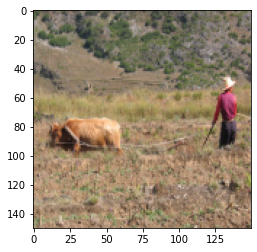

********************
**********************
701.8972748645257 905.3399794404721


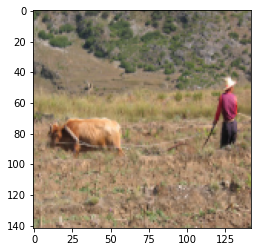

******************
********************
564.782224217193 702.5635819500177


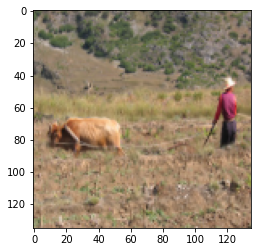

****************
******************
476.3537752785102 604.349228195042


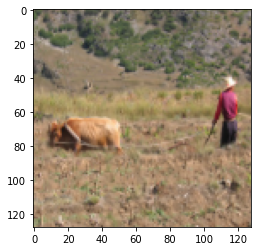

**************
****************
375.5184385366166 455.90096508398267


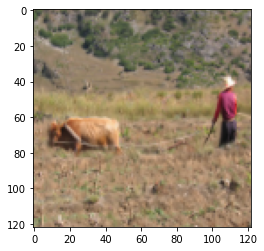

*************
**************
323.13857963739997 394.67036620312246


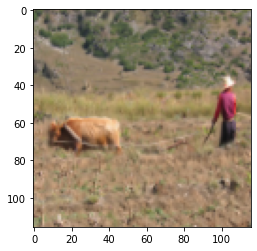

************
*************
284.3005360546225 350.70712583040756


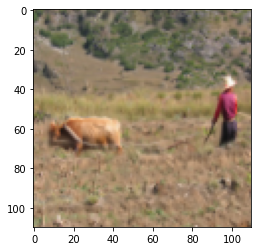

**********
************
234.02632665002352 293.4272834457016


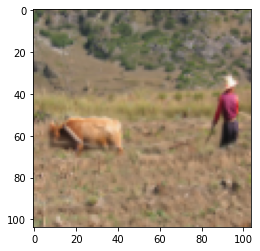

**********
**********
198.67086401311042 237.9843535400161


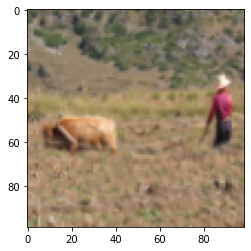

*********
**********
180.02577102754896 217.18098503082354


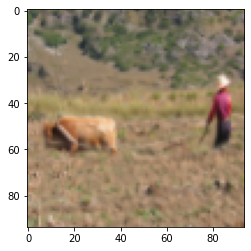

********
*********
149.24510265009286 182.85268847346265


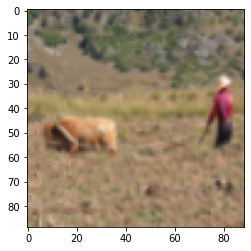

*******
********
126.30728239207595 150.43935193360863


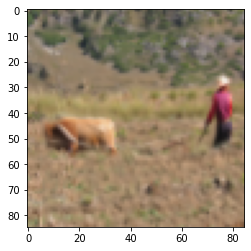

******
*******
122.44547205492916 146.11116720569555


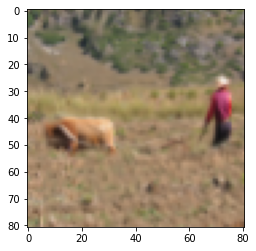

******
******
117.12917650754747 140.61170526554685


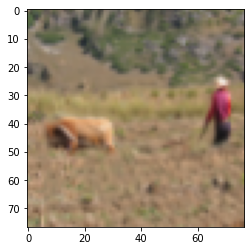

*****
******
101.47876737115641 121.6753858253895


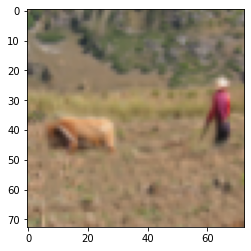

*****
*****
80.47619793815008 97.61063308566675


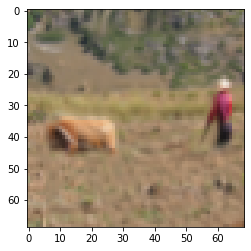

****
*****
65.42615547634358 76.7622898595765


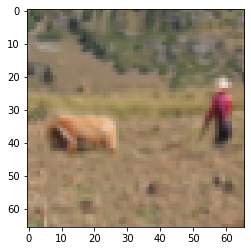

****
****
58.486450075628596 68.79422364306117


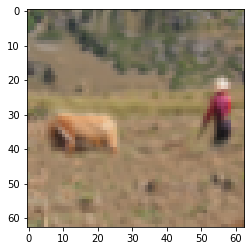

****
****
54.85618695486055 65.88248857087162


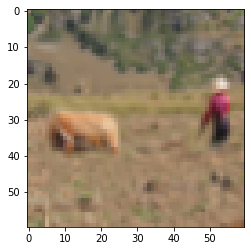

***
****
53.87278829737829 64.77916394280106


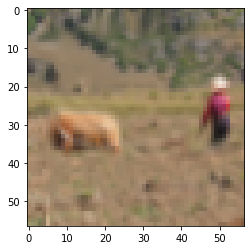

***
***
49.69473099327662 60.154101652992225


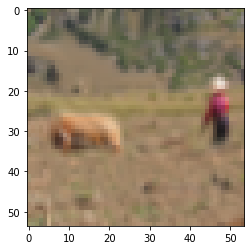

In [17]:
S=cv2.imread('./../../hi.png')
S=cv2.resize(S,(150,150))
S=cv2.cvtColor(S,cv2.COLOR_BGR2RGB)
img=S.copy()
T=S.copy()
plt.imshow(T)
plt.show()
#window size=7*7 always
for _ in range(20):
    img=cv2.resize(img,None,fx=0.95,fy=0.95)
    T=cv2.resize(S,None,fx=0.95,fy=0.95)
    #plt.figure(figsize=(10,10))
    #plt.subplot(211)
    #plt.imshow(img)
    out=T.copy()
    match1,me1=NCC_best_patch1(T,S)
    match2,me2=NCC_best_patch2(S,T)
    print(me1,me2)
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            cnt1=0
            sum1=np.array([0,0,0])
            cnt2=0
            sum2=np.array([0,0,0])
            for x in range(5): 
                for y in range(5):
                    try :
                        here=match1[(i-x,j-y)]
                        sum1=sum1+S[here[0]+x,here[1]+y]
                        cnt1=cnt1+1
                    except :
                        continue
            for x in range(5):
                for y in range(5):
                    try :
                        here=match2[(i-x,j-y)]
                        sum2=sum2+S[here[0]+x,here[1]+y]
                        cnt2=cnt2+1
                    except :
                        continue
            out[i,j]=np.array((sum1+sum2)/(cnt1+cnt2),int)
    T=out.copy()
    #plt.subplot(212)
    plt.imshow(T)
    plt.show()
    S=T.copy()

In [ ]:
S=cv2.imread('./../../hi.png')
S=cv2.resize(S,(150,150))
S=cv2.cvtColor(S,cv2.COLOR_BGR2RGB)
img=S.copy()
T=S.copy()
plt.imshow(T)
plt.show()
#window size=7*7 always
for _ in range(20):
    img=cv2.resize(img,None,fx=0.95,fy=0.95)
    T=cv2.resize(S,None,fx=0.95,fy=0.95)
    #plt.figure(figsize=(10,10))
    #plt.subplot(211)
    #plt.imshow(img)
    out=T.copy()
    match1,me1=NCC_best_patch1(T,S)
    match2,me2=NCC_best_patch2(S,T)
    print(me1,me2)
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            cnt1=0
            sum1=np.array([0,0,0])
            cnt2=0
            sum2=np.array([0,0,0])
            for x in range(5): 
                for y in range(5):
                    try :
                        here=match1[(i-x,j-y)]
                        sum1=sum1+S[here[0]+x,here[1]+y]
                        cnt1=cnt1+1
                    except :
                        continue
            for x in range(5):
                for y in range(5):
                    try :
                        here=match2[(i-x,j-y)]
                        sum2=sum2+S[here[0]+x,here[1]+y]
                        cnt2=cnt2+1
                    except :
                        continue
            out[i,j]=np.array((sum1+sum2)/(cnt1+cnt2),int)
    T=out.copy()
    #plt.subplot(212)
    plt.imshow(T)
    plt.show()
    S=T.copy()

In [14]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
b=np.array([1,2,3])
print(a.shape())
print(a*b)

TypeError: 'tuple' object is not callable